In [261]:
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import seaborn as sns

In [3]:
'''  
X <- Serie de tiempo de Ticker 1
Y <- Serie de tiempo de Ticker 2
'''
def distancia_correlacion(X, Y):
    cor = np.corrcoef(X,Y)[0,1]
    metrica = np.sqrt(0.5*(1-cor))
    return metrica

In [4]:
def distancia_correlacion(df):
    cor = df.corr()
    metrica = np.sqrt(0.5*(1-cor))
    return metrica

In [5]:
'''  
X <- Serie de tiempo de Ticker 1
Y <- Serie de tiempo de Ticker 2
bins <- Tamaño partición
norm <- boolean False si las series no están normalizadas
'''
#---------------------------------------------------
def varInfo(X,Y,bins,norm=False):
    # variation of information
    cXY=np.histogram2d(X,Y,bins)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=entropy(np.histogram(X,bins)[0]) # marginal
    hY=entropy(np.histogram(Y,bins)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

# Leemos Tickers

In [494]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2022, 6, 23)

tickers =  ['ATVI', 'ADBE', 'AMD', 'ALGN', 'GOOG', 'GOOGL', 'AMZN', 'AMGN', 'ADI', 'AAPL', 'AMAT', 'ASML', 'ADSK',
    'ADP','BIDU', 'BIIB', 'BMRN', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 
    'CTXS', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CSX', 'DXCM' ,'DOCU' ,'DLTR' ,'EBAY', 'EA' ,'EXC','EXPE','FB', 
    'FAST', 'FISV', 'FOX', 'FOXA', 'GILD', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG',
    'JD', 'KLAC', 'LRCX', 'LBTYA', 'LULU', 'MAR', 'MELI', 'MCHP', 'MU', 'MSFT','MRNA', 'MDLZ', 'MNST', 'NTES', 
    'NFLX' ,'NVDA', 'NXPI', 'ORLY', 'PCAR', 'PAYX', 'PYPL', 'PEP', 'PDD', 'QCOM', 'REGN', 'ROST',
    'SGEN', 'SIRI', 'SWKS', 'SPLK', 'SBUX', 'SNPS', 'TMUS', 'TTWO','TSLA', 'TXN', 'KHC', 'TCOM', 
    'ULTA', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDC', 'WDAY', 'XEL', 'ZM', 'TGT','BTC', 'BABA']

data = yf.download(tickers, start, end)['Adj Close'].dropna()

In [157]:
d_cor = distancia_correlacion(data)

In [158]:
d_cor

,ADBE,ALGN,AMD,ATVI,GOOG
ADBE,0.000000,0.278669,0.131872,0.446887,0.177165
ALGN,0.278669,0.000000,0.304735,0.408104,0.197882
AMD,0.131872,0.304735,0.000000,0.481478,0.209329
ATVI,0.446887,0.408104,0.481478,0.000000,0.465009
GOOG,0.177165,0.197882,0.209329,0.465009,0.000000


<AxesSubplot:>

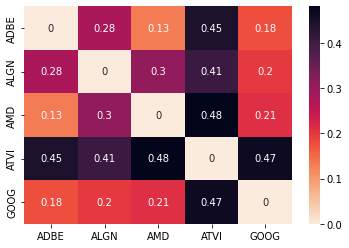

In [160]:
sns.heatmap(d_cor, cmap = sns.cm.rocket_r, annot=True)

<AxesSubplot:>

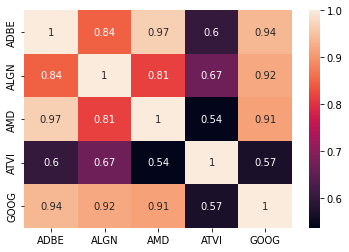

In [167]:
sns.heatmap(data.corr(), cmap = sns.cm.rocket, annot=True)

In [33]:
varinfo_matrix = np.zeros([data.shape[1], data.shape[1]])
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        varinfo_matrix[i,j] = varInfo(data.iloc[:,i], data.iloc[:,j], bins = 50)

<AxesSubplot:>

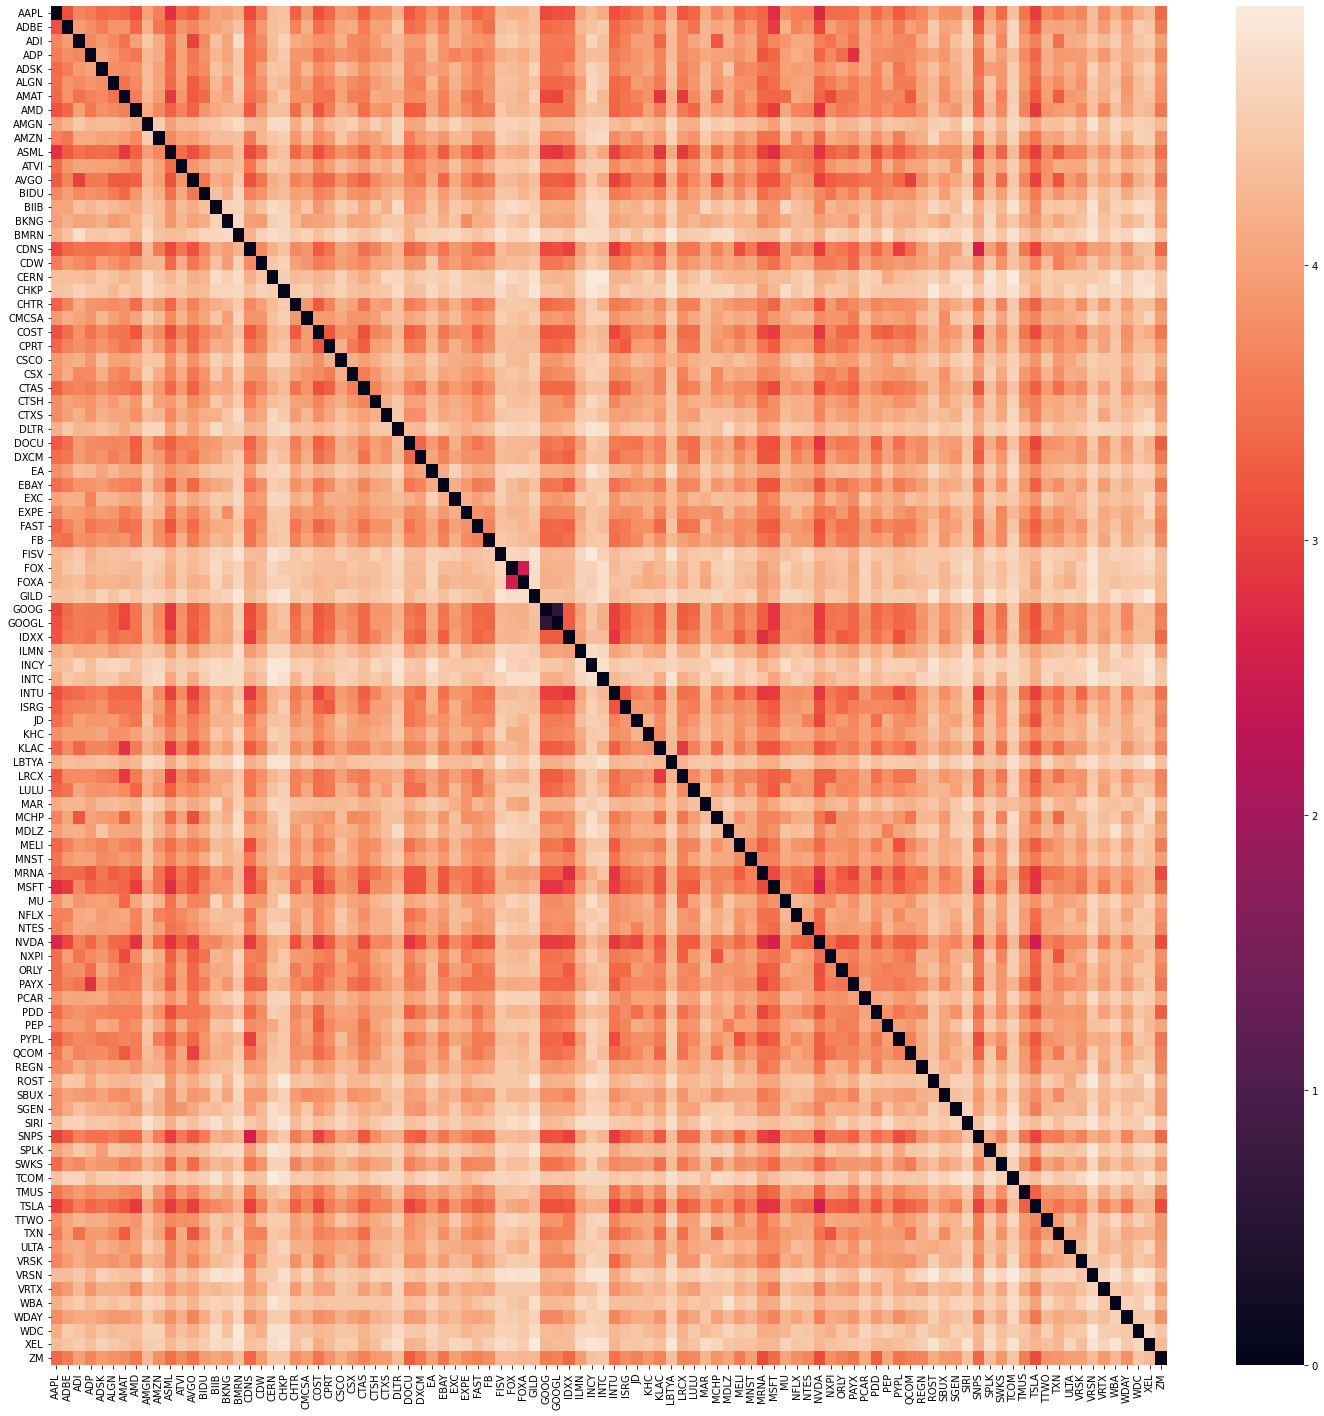

In [40]:
plt.figure(figsize=(25,25))
sns.heatmap(varinfo_matrix, cmap = sns.cm.rocket, xticklabels=sorted(tickers), yticklabels=sorted(tickers))

# Calculamos métricas

In [212]:
d_corr = distancia_correlacion(data)


for i in range(d_corr.shape[0]):

  d_corr.iloc[i][i] = 1.0

corr = d_corr[(d_corr < .2)].notna()

correlatedColumns = list(corr.sum()[corr.sum() > 0].index)

df_d_corr = data[correlatedColumns]

In [112]:
corr = data.corr()

#Se aplica correlacion

for i in range(corr.shape[0]):

  corr.iloc[i][i] = 0

corr = corr[(corr > .9)].notna()

correlatedColumns = list(corr.sum()[corr.sum() > 0].index)

data_corr = data[correlatedColumns]

In [113]:
data_corr

,AAPL,ADBE,ADI,ADP,ADSK,ALGN,AMAT,AMD,AMZN,ASML,...,REGN,SBUX,SNPS,SWKS,TMUS,TSLA,TTWO,TXN,VRSK,WDAY
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-18,49.551826,270.570007,107.919548,151.803238,169.199997,281.489990,42.320339,27.680000,93.084503,198.277985,...,333.339996,71.467178,115.980003,85.396492,73.750000,54.652000,90.739998,106.027542,135.119385,187.830002
2019-04-22,49.714691,272.209991,106.810158,151.307953,172.149994,290.630005,42.166275,28.180000,94.365501,197.892807,...,334.029999,70.847046,116.989998,83.754990,73.720001,52.549999,91.919998,105.513519,134.776657,189.369995
2019-04-23,50.431736,278.489990,107.280220,154.233002,175.279999,296.079987,42.204800,27.969999,96.188499,197.680939,...,344.140015,71.401398,119.889999,84.675385,73.750000,52.779999,93.290001,106.826126,136.568604,195.199997
2019-04-24,50.353962,275.450012,110.269897,152.793839,176.309998,297.079987,42.811432,28.459999,95.087502,197.796524,...,340.459991,71.777252,119.870003,85.301620,73.330002,51.731998,93.599998,108.707855,136.597977,195.369995
2019-04-25,49.896980,277.660004,108.135750,153.130264,175.320007,296.739990,42.801804,27.660000,95.112503,198.566864,...,349.989990,72.453766,119.699997,84.001686,72.709999,49.526001,92.900002,107.551270,135.902756,198.820007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,179.836319,577.679993,173.808624,243.909973,284.299988,661.070007,162.030945,154.360001,169.669495,805.476624,...,634.770020,112.848969,375.589996,153.881042,118.580002,1093.939941,179.559998,189.290878,226.587433,279.350006
2021-12-28,178.799164,569.359985,172.728943,243.692108,282.769989,656.369995,158.963989,153.149994,170.660995,798.865540,...,638.460022,114.182755,372.149994,154.455536,118.160004,1088.469971,179.389999,188.560730,227.255005,275.799988
2021-12-29,178.888916,569.289978,173.858154,245.613358,282.570007,653.340027,160.298309,148.259995,169.201004,796.095947,...,647.280029,114.983025,373.440002,154.881424,117.639999,1086.189941,180.300003,188.274582,228.470596,275.750000


In [31]:
varinfo_matrix = np.zeros([data.shape[1], data.shape[1]])
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        varinfo_matrix[i,j] = varInfo(data.iloc[:,i], data.iloc[:,j], bins = 50)

varinfo_matrix = pd.DataFrame(varinfo_matrix, columns=sorted(tickers))

for i in range(varinfo_matrix.shape[0]):

  varinfo_matrix.iloc[i][i] = 100.0

varinfo_matrix = varinfo_matrix[(varinfo_matrix < 3.0)].notna()

correlatedColumns = list(varinfo_matrix.sum()[varinfo_matrix.sum() > 0].index)

data_varinfo = data[correlatedColumns]



In [32]:
data_varinfo

,AAPL,ADBE,ADP,AMAT,AMD,ASML,AVGO,CDNS,COST,DOCU,...,KLAC,LRCX,MRNA,MSFT,NVDA,PAYX,PYPL,QCOM,SNPS,TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-18,49.551826,270.570007,151.803238,42.320339,27.680000,198.277985,283.240479,63.369999,233.323792,52.790001,...,117.817673,185.812119,22.510000,119.282494,46.306980,74.373199,107.360001,73.918320,115.980003,54.652000
2019-04-22,49.714691,272.209991,151.307953,42.166275,28.180000,197.892807,280.022522,64.209999,231.055176,54.130001,...,116.745743,186.241425,23.629999,119.659569,46.846355,74.391426,106.809998,75.842842,116.989998,52.549999
2019-04-23,50.431736,278.489990,154.233002,42.204800,27.969999,197.680939,280.591400,66.699997,233.105499,55.240002,...,116.831123,185.821655,24.700001,121.283920,47.393188,76.187164,106.900002,80.237793,119.889999,52.779999
2019-04-24,50.353962,275.450012,152.793839,42.811432,28.459999,197.796524,279.426849,67.650002,235.364578,55.840000,...,119.183670,186.451340,25.760000,120.868164,47.517471,76.096031,107.220001,80.339554,119.870003,51.731998
2019-04-25,49.896980,277.660004,153.130264,42.801804,27.660000,198.566864,277.195587,67.489998,233.124466,57.009998,...,118.965500,195.647949,25.740000,124.870987,46.458603,75.868126,110.220001,78.711113,119.699997,49.526001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,179.836319,577.679993,243.909973,162.030945,154.360001,805.476624,664.244202,191.649994,561.703369,156.520004,...,437.523560,718.667114,246.880005,340.949280,309.331909,133.951111,192.009995,184.584259,375.589996,1093.939941
2021-12-28,178.799164,569.359985,243.692108,158.963989,153.149994,798.865540,659.042725,190.080002,562.869751,152.389999,...,429.551758,711.414795,241.440002,339.754517,303.104248,134.158508,190.100006,183.088409,372.149994,1088.469971
2021-12-29,178.888916,569.289978,245.613358,160.298309,148.259995,796.095947,662.598999,189.929993,565.989929,152.479996,...,432.464142,721.995178,247.880005,340.451477,299.895508,135.669464,189.970001,184.455460,373.440002,1086.189941


# Primer Filtro

In [12]:
class paresTrading:

  def __init__(self, ticker, start, end, minCorrelation = .98):

    self.start = start

    self.end = end

    self.minCorrlation = minCorrelation

    #descargar los datos y guardarlos en un dataframe que se llame self.df

    self.df = yf.download(tickers, start, end)['Adj Close'].dropna()



  def correlationTest(self):

    corr = self.df.corr()

    #Se aplica correlacion

    for i in range(corr.shape[0]):

      corr.iloc[i][i] = 0

    corr = corr[(corr > .8)].notna()

    correlatedColumns = list(corr.sum()[corr.sum() > 0].index)

    data = self.df[correlatedColumns]

    #Se aplica cointegracion

    self.pairs = []

    for i in range(data.shape[1]):

        for j in range(i+1, data.shape[1]):

            resultado = coint(data[data.columns[i]], data[data.columns[j]])

            if resultado[1] <= 0.001:

                self.pairs.append((data.columns[i], data.columns[j]))

    #Se aplica correlacion en serie de tiempo

    return self.pairs

    

  def variationalInformationTest(self):
    varinfo_matrix = np.zeros([self.df.shape[1], self.df.shape[1]])
    for i in range(self.df.shape[1]):
      for j in range(self.df.shape[1]):
        varinfo_matrix[i,j] = varInfo(self.df.iloc[:,i], self.df.iloc[:,j], bins = 50)

    varinfo_matrix = pd.DataFrame(varinfo_matrix, columns=sorted(tickers))


    for i in range(varinfo_matrix.shape[0]):

      varinfo_matrix.iloc[i][i] = 100.0

    varinfo_matrix = varinfo_matrix[(varinfo_matrix < 3.0)].notna()

    correlatedColumns = list(varinfo_matrix.sum()[varinfo_matrix.sum() > 0].index)

    data = self.df[correlatedColumns]

    #Se aplica cointegracion

    self.pairs_varinfo = []

    for i in range(data.shape[1]):

      for j in range(i+1, data.shape[1]):

        resultado = coint(data[data.columns[i]], data[data.columns[j]])

        if resultado[1] <= 0.1:

          self.pairs_varinfo.append((data.columns[i], data.columns[j]))

    return self.pairs_varinfo

In [13]:
modelo = paresTrading(tickers, start, end)

[*********************100%***********************]  99 of 99 completed


In [18]:
var_info = modelo.variationalInformationTest()
var_info

[('AAPL', 'AMD'),
 ('ADP', 'PAYX'),
 ('AMD', 'SNPS'),
 ('ASML', 'GOOG'),
 ('ASML', 'GOOGL'),
 ('ASML', 'IDXX'),
 ('ASML', 'TGT'),
 ('AVGO', 'KLAC'),
 ('CDNS', 'SNPS'),
 ('CDNS', 'TSLA'),
 ('COST', 'NVDA'),
 ('IDXX', 'MRNA'),
 ('IDXX', 'TGT'),
 ('KLAC', 'SNPS'),
 ('KLAC', 'TSLA'),
 ('MSFT', 'NVDA'),
 ('NVDA', 'SNPS'),
 ('QCOM', 'TSLA')]

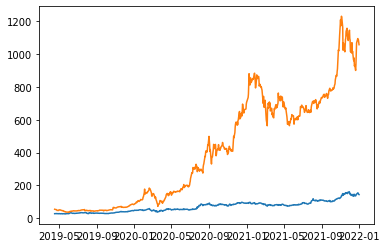

In [22]:
plt.plot(modelo.df['AMD'])
plt.plot(modelo.df['TSLA'])

# Filtro Mejorado

In [433]:
class paresTrading:

    def __init__(self, tickers, start, end):

        self.start = start

        self.end = end

        self.tickers = sorted(tickers)

        #descargar los datos y guardarlos en un dataframe que se llame self.df

        self.df = yf.download(tickers, start, end)['Adj Close'].dropna()

        self.data_filtration = self.df.copy()

        self.pairs = []

        for i in range(len(self.tickers)):
            for j in range(i+1,len(self.tickers)):
                self.pairs.append((self.tickers[i],self.tickers[j]))
    



    def correlationTest(self, tol = 0.9):
         

        for pair in self.pairs:

                resultado = np.corrcoef(self.data_filtration[pair[0]],self.data_filtration[pair[1]])[0,1]
                if resultado < tol:

                    self.pairs.remove(pair)
            
    #corr = corr.loc[(corr>tol).any(axis=1)]
            
        self.__filter_data()



    def cointegration(self, tol=0.1):

        for pair in self.pairs:

                resultado = coint(self.data_filtration[pair[0]], self.data_filtration[pair[1]])[1]

                if resultado > tol:

                    self.pairs.remove(pair)
                    
        self.__filter_data()
   
                


    def variationalInformationTest(self, bins = 50, tol = 3.0):
    
        for pair in self.pairs:

            resultado = varInfo(self.data_filtration[pair[0]],self.data_filtration[pair[1]], bins = bins)

            if resultado > tol:

                self.pairs.remove(pair)
                
        self.__filter_data()

    
    def clear_filter(self):

        self.pairs = []
        self.data_filtration = self.df.copy()

        for i in range(len(self.tickers)):
            for j in range(i+1,len(self.tickers)):
                self.pairs.append((self.tickers[i],self.tickers[j]))
            
  
    def __filter_data(self):
    
        unique_tickers = []
        
        for pair in self.pairs:
            if pair[0] not in unique_tickers:
                unique_tickers.append(pair[0])
            if pair[1] not in unique_tickers:
                unique_tickers.append(pair[1])
        
        self.data_filtration = self.data_filtration[unique_tickers]
    
    
    





In [399]:
modelo = paresTrading(tickers, start, end)

modelo.clear_filter()

[*********************100%***********************]  30 of 30 completed


In [486]:
modelo.correlationTest(tol=0.9)


In [487]:
modelo.variationalInformationTest(tol = 4.0)

In [488]:
modelo.cointegration(tol=0.5)

In [491]:
modelo.pairs

[('AAPL', 'ADI'),
 ('AAPL', 'AMD'),
 ('AAPL', 'FAST'),
 ('AAPL', 'GOOGL'),
 ('AAPL', 'NVDA'),
 ('AAPL', 'QCOM'),
 ('ADI', 'AMAT'),
 ('ADI', 'ASML'),
 ('ADI', 'GOOG'),
 ('ADI', 'GOOGL'),
 ('ADI', 'NVDA'),
 ('ADI', 'QCOM'),
 ('ADP', 'ORLY'),
 ('ADP', 'PAYX'),
 ('ADP', 'PEP'),
 ('ADSK', 'PYPL'),
 ('AMAT', 'ASML'),
 ('AMAT', 'FAST'),
 ('AMAT', 'GOOG'),
 ('AMAT', 'GOOGL'),
 ('AMD', 'ASML'),
 ('AMD', 'FAST'),
 ('AMD', 'GOOG'),
 ('AMD', 'GOOGL'),
 ('AMD', 'NVDA'),
 ('AMD', 'QCOM'),
 ('ASML', 'FAST'),
 ('ASML', 'GOOG'),
 ('ASML', 'GOOGL'),
 ('FAST', 'GOOG'),
 ('FAST', 'GOOGL'),
 ('FAST', 'NVDA'),
 ('FAST', 'ORLY'),
 ('FAST', 'QCOM'),
 ('FOX', 'FOXA'),
 ('GOOG', 'GOOGL'),
 ('GOOG', 'NVDA'),
 ('GOOG', 'ORLY'),
 ('GOOGL', 'NVDA'),
 ('GOOGL', 'ORLY'),
 ('NVDA', 'ORLY'),
 ('NVDA', 'QCOM'),
 ('ORLY', 'PAYX'),
 ('ORLY', 'PEP'),
 ('PAYX', 'PEP')]

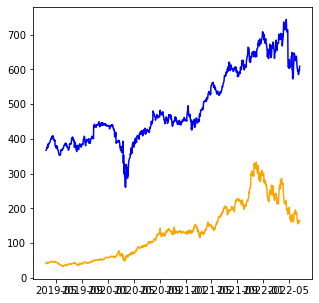

In [492]:
A = "NVDA"
B = "ORLY"

plt.figure(figsize=(5,5))
plt.plot(modelo.df[A], c= 'orange')
plt.plot(modelo.df[B], c='blue')

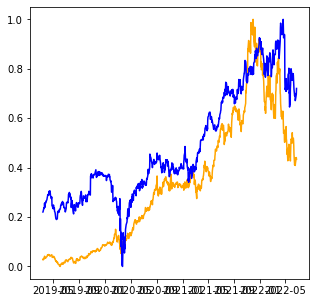

In [493]:
plt.figure(figsize=(5,5))
plt.plot((modelo.df[A]-np.min(modelo.df[A]))/(np.max(modelo.df[A]) - np.min(modelo.df[A])), c='orange')
plt.plot((modelo.df[B]-np.min(modelo.df[B]))/(np.max(modelo.df[B]) - np.min(modelo.df[B])), c="blue")
